Step 1: Resample Prediction Bands from 10m to 20m (for Training)
To train the model, you need both predictors (X) and target (y) at the same resolution. Resample your 10m prediction bands to 20m to match the observed dNBR:

In [1]:
# import rasterio
# from rasterio.enums import Resampling
# import numpy as np

# def resample_to_coarse(input_path, output_path, target_resolution=20):
#     """
#     Resample 10m prediction bands to 20m resolution
#     """
#     with rasterio.open(input_path) as src:
#         # Calculate scale factor (downsampling from 10m to 20m)
#         scale_factor = target_resolution / src.res[0]  # 20/10 = 0.5
        
#         # Read and resample data
#         data = src.read(
#             out_shape=(
#                 src.count,
#                 int(src.height * scale_factor),
#                 int(src.width * scale_factor)
#             ),
#             resampling=Resampling.average  # Use average for downsampling
#         )
        
#         # Update transform
#         transform = src.transform * src.transform.scale(
#             (src.width / data.shape[-1]),
#             (src.height / data.shape[-2])
#         )
        
#         # Write resampled raster
#         profile = src.profile.copy()
#         profile.update({
#             'height': data.shape[1],
#             'width': data.shape[2],
#             'transform': transform
#         })
        
#         with rasterio.open(output_path, 'w', **profile) as dst:
#             dst.write(data)
    
#     print(f"Resampled to {target_resolution}m: {output_path}")

# # Resample prediction bands from 10m to 20m for training
# resample_to_coarse(
#     '/Users/ceedindia/Desktop/Fire/Data/GSE_Bandipur_Prediction_Band.tif', 
#     '/Users/ceedindia/Desktop/Fire/Data/GSE_Bandipur_prediction_bands_20m.tif', 
#     target_resolution=20
# )


In [2]:
# import rasterio

# input_path = '/Users/ceedindia/Desktop/Fire/Data/Trial/GSE_Dirang_Prediction_Band.tif'
# output_path = '/Users/ceedindia/Desktop/Fire/Data/Trial/GSE_Dirang_Prediction_Band_after64.tif'

# with rasterio.open(input_path) as src:
#     # Select bands after the first 64
#     bands_to_keep = list(range(65, src.count + 1))
#     profile = src.profile
#     profile.update(count=len(bands_to_keep))

#     with rasterio.open(output_path, 'w', **profile) as dst:
#         for new_idx, old_idx in enumerate(bands_to_keep, start=1):
#             dst.write(src.read(old_idx), new_idx)
#             if src.descriptions:
#                 dst.set_band_description(new_idx, src.descriptions[old_idx - 1])

# print("Successfully created a new file without the first 64 bands:", output_path)

In [3]:
# import rasterio
# from rasterio.warp import calculate_default_transform, reproject, Resampling

# def resample_to_coarse(input_path, output_path, target_resolution=20):
#     """
#     Resample 10m prediction bands to 20m resolution safely (works in meters).
#     If CRS is geographic (EPSG:4326), reproject to a projected CRS first.
#     """
#     with rasterio.open(input_path) as src:
#         # If CRS is in degrees, switch to UTM (based on the raster center)
#         if src.crs.is_geographic:
#             lon, lat = (src.bounds.left + src.bounds.right)/2, (src.bounds.top + src.bounds.bottom)/2
#             utm_zone = int((lon + 180) / 6) + 1
#             new_crs = f"EPSG:{32600 + utm_zone if lat >= 0 else 32700 + utm_zone}"
#             print(f"Reprojecting from {src.crs} → {new_crs} for meter-based resampling...")
#         else:
#             new_crs = src.crs

#         transform, width, height = calculate_default_transform(
#             src.crs, new_crs, src.width, src.height, *src.bounds, resolution=target_resolution
#         )

#         profile = src.profile.copy()
#         profile.update({
#             "crs": new_crs,
#             "transform": transform,
#             "width": width,
#             "height": height
#         })

#         with rasterio.open(output_path, "w", **profile) as dst:
#             for i in range(1, src.count + 1):
#                 reproject(
#                     source=rasterio.band(src, i),
#                     destination=rasterio.band(dst, i),
#                     src_transform=src.transform,
#                     src_crs=src.crs,
#                     dst_transform=transform,
#                     dst_crs=new_crs,
#                     resampling=Resampling.average
#                 )

#     print(f"✅ Resampled raster saved to {output_path}")

In [4]:
# resample_to_coarse(
#     '/Users/ceedindia/Desktop/Fire/Data/Trial/GSE_Dirang_Prediction_Band_after64.tif',
#     '/Users/ceedindia/Desktop/Fire/Data/Trial/GSE_Dirang_Prediction_Band_after64.tif_resampled20.tif',
#     target_resolution=20
# )

Step 2: Convert 20m Rasters to DataFrame (Training Data)

In [5]:
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np

def raster_to_dataframe_20m(prediction_20m_path, observed_20m_path):
    """
    Convert 20m resolution rasters to dataframe for training.
    Automatically aligns observed raster to prediction raster grid.
    """
    # Read prediction bands
    with rasterio.open(prediction_20m_path) as pred_src:
        pred_data = pred_src.read()  # (n_bands, height, width)
        n_bands = pred_src.count
        height, width = pred_src.height, pred_src.width
        transform = pred_src.transform
        crs = pred_src.crs
        
        # Coordinates
        rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
        xs, ys = rasterio.transform.xy(transform, rows.flatten(), cols.flatten())

        # Flatten prediction data
        pred_data_flat = pred_data.reshape(n_bands, -1).T
        df = pd.DataFrame(pred_data_flat, columns=[f'band_{i+1}' for i in range(n_bands)])
        df['longitude'] = xs
        df['latitude'] = ys

    # Read observed raster and align to prediction grid
    with rasterio.open(observed_20m_path) as obs_src:
        obs_data = np.empty((height, width), dtype=np.float32)
        reproject(
            source=rasterio.band(obs_src, 1),
            destination=obs_data,
            src_transform=obs_src.transform,
            src_crs=obs_src.crs,
            dst_transform=transform,
            dst_crs=crs,
            resampling=Resampling.bilinear
        )
        df['observed_dnbr'] = obs_data.flatten()

    # Clean dataframe
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    return df

df_train_20m = raster_to_dataframe_20m(
    '/Users/ceedindia/Desktop/Fire/Data/Trial/GSE_Dirang_Prediction_Band_after64.tif_resampled20.tif',
    '/Users/ceedindia/Desktop/Fire/Data/Trial/Observed_dNBR_20m_Dirang.tif'
)
print(f"Training data shape: {df_train_20m.shape}")

Training data shape: (7798, 69)


Step 3: Prepare Training Data

In [6]:
# Separate features and target
feature_cols = [col for col in df_train_20m.columns if col.startswith('band_')]
X_20m = df_train_20m[feature_cols]
y_20m = df_train_20m['observed_dnbr']

print(f"Training Features (20m): {X_20m.shape}")
print(f"Training Target (20m): {y_20m.shape}")


Training Features (20m): (7798, 66)
Training Target (20m): (7798,)


# VIF (Variance Inflation Factor)

In [7]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF and remove features above threshold
def calculate_vif(X, threshold=10):
    """
    Iteratively removes features with VIF greater than the given threshold.
    """
    variables = X.columns.tolist()
    dropped = True

    while dropped:
        dropped = False
        vif = pd.DataFrame()
        vif["Feature"] = variables
        vif["VIF"] = [variance_inflation_factor(X[variables].values, i) for i in range(X[variables].shape[1])]

        max_vif = vif["VIF"].max()
        if max_vif > threshold:
            max_vif_feature = vif.loc[vif["VIF"] == max_vif, "Feature"].values[0]
            print(f"Dropping '{max_vif_feature}' with VIF = {max_vif:.2f}")
            variables.remove(max_vif_feature)
            dropped = True

    print("\nFinal set of features after VIF filtering:")
    print(variables)
    return X[variables], vif

# Run VIF calculation on training features (20m)
X_20m_vif, vif_20m = calculate_vif(X_20m, threshold=10)

# View final VIF table
print("\nFinal VIF values:")
print(vif_20m)

Dropping 'band_65' with VIF = 5304.21
Dropping 'band_59' with VIF = 1295.44
Dropping 'band_43' with VIF = 975.25
Dropping 'band_60' with VIF = 871.14
Dropping 'band_48' with VIF = 811.04
Dropping 'band_35' with VIF = 792.61
Dropping 'band_4' with VIF = 752.41
Dropping 'band_13' with VIF = 723.06
Dropping 'band_3' with VIF = 608.75
Dropping 'band_54' with VIF = 492.61
Dropping 'band_53' with VIF = 446.78
Dropping 'band_17' with VIF = 390.43
Dropping 'band_8' with VIF = 386.62
Dropping 'band_22' with VIF = 361.84
Dropping 'band_16' with VIF = 354.88
Dropping 'band_2' with VIF = 335.14
Dropping 'band_10' with VIF = 304.48
Dropping 'band_46' with VIF = 291.04
Dropping 'band_20' with VIF = 268.79
Dropping 'band_58' with VIF = 263.09
Dropping 'band_24' with VIF = 210.72
Dropping 'band_42' with VIF = 173.54
Dropping 'band_36' with VIF = 166.38
Dropping 'band_64' with VIF = 162.42
Dropping 'band_12' with VIF = 154.78
Dropping 'band_29' with VIF = 154.16
Dropping 'band_32' with VIF = 148.30
Dro

In [8]:
X_20m = X_20m_vif

Step 4: Train-Test Split (70:30)

In [9]:
print("X_20m shape:", X_20m.shape)
print("y_20m shape:", y_20m.shape)

X_20m shape: (7798, 20)
y_20m shape: (7798,)


In [10]:
from sklearn.model_selection import train_test_split

# Split data 70:30
X_train, X_test, y_train, y_test = train_test_split(
    X_20m, y_20m, test_size=0.30, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 5458
Testing samples: 2340


Step 5: Random Forest with Hyperparameter Tuning (10-fold CV)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Hyperparameter grid
rf_param_grid = {
    'n_estimators': [500, 1000, 2000], # 500, 1000, 2000 # 500,
    'max_depth': [10, 20, 30, None], ## 10 30 50  10, 
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', None] ## sqrt , 'log2', 
}

# Initialize Random Forest
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# GridSearchCV with 10-fold CV
print("Random Forest hyperparameter tuning (10-fold CV)...")
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

rf_grid_search.fit(X_train, y_train)
print(f"\nBest RF parameters: {rf_grid_search.best_params_}")
best_rf_model = rf_grid_search.best_estimator_


Random Forest hyperparameter tuning (10-fold CV)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=500; total time=   4.4s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=500; total time=   4.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=500; total time=   4.6s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time=   9.7s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time=  10.0s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time=  10.0s
[CV] END ..max_depth=10, max_features=None, n_estimators=500; total time=  18.7s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=2000; total time=  19.1s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=2000; total time=  19.2s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=2000; total time=  19.6s
[CV] END ..max_depth=10, max_features=None, n_estimators=500; total time=  19

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .max_depth=20, max_features=sqrt, n_estimators=1000; total time=  13.6s
[CV] END .max_depth=20, max_features=sqrt, n_estimators=1000; total time=  13.8s
[CV] END .max_depth=10, max_features=None, n_estimators=1000; total time=  37.5s
[CV] END .max_depth=10, max_features=None, n_estimators=1000; total time=  34.9s
[CV] END .max_depth=10, max_features=None, n_estimators=1000; total time=  35.4s
[CV] END .max_depth=20, max_features=sqrt, n_estimators=2000; total time=  23.8s
[CV] END .max_depth=20, max_features=sqrt, n_estimators=2000; total time=  24.2s
[CV] END ..max_depth=20, max_features=None, n_estimators=500; total time=  22.6s
[CV] END ..max_depth=20, max_features=None, n_estimators=500; total time=  22.9s
[CV] END .max_depth=20, max_features=sqrt, n_estimators=2000; total time=  23.8s
[CV] END ..max_depth=20, max_features=None, n_estimators=500; total time=  24.3s
[CV] END .max_depth=10, max_features=None, n_estimators=2000; total time= 1.2min
[CV] END ..max_depth=30, max

In [12]:
# import itertools
# import time
# from tqdm import tqdm
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestRegressor
# import numpy as np

# # Define parameter grid
# rf_param_grid = {
#     'n_estimators': [500, 1000],
#     'max_depth': [20, 30, None],
#     'max_features': ['sqrt', None]
# }

# # Generate all parameter combinations
# param_combinations = list(itertools.product(
#     rf_param_grid['n_estimators'],
#     rf_param_grid['max_depth'],
#     rf_param_grid['max_features']
# ))

# print(f"Total combinations to test: {len(param_combinations)}")

# results = []

# # Start progress bar
# for params in tqdm(param_combinations, desc="Grid Search Progress", unit="combination"):
#     n_estimators, max_depth, max_features = params
    
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         max_features=max_features,
#         random_state=42,
#         n_jobs=-1
#     )
    
#     # 3-fold cross-validation
#     scores = cross_val_score(model, X_train, y_train, cv=3,
#                              scoring='neg_mean_squared_error', n_jobs=-1)
    
#     results.append({
#         'n_estimators': n_estimators,
#         'max_depth': max_depth,
#         'max_features': max_features,
#         'mean_score': np.mean(scores)
#     })

# # Find best combination
# best = max(results, key=lambda x: x['mean_score'])
# print("\n✅ Best Parameters:")
# print(best)

Step 6: 10-Fold Cross-Validation on Best RF Model

In [13]:
# 5-fold CV on best model
rf_cv_scores_5fold = cross_val_score(
    best_rf_model, X_train, y_train, 
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rf_cv_rmse = np.sqrt(-rf_cv_scores_5fold.mean())
print(f"RF 10-fold CV RMSE: {rf_cv_rmse:.4f}")


RF 10-fold CV RMSE: 0.0731


Step 7: Test Set Evaluation for RF

In [14]:
# # Predict and evaluate
# y_pred_rf = best_rf_model.predict(X_test)

# rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# rf_r2 = r2_score(y_test, y_pred_rf)

# print(f"\nRF Test Performance:")
# print(f"RMSE: {rf_rmse:.4f}")
# print(f"R²: {rf_r2:.4f}")


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Predict and evaluate
y_pred_rf = best_rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# Mean Absolute Percentage Error (MAPE)
# Avoid division by zero
non_zero_mask = y_test != 0
rf_mape = np.mean(np.abs((y_test[non_zero_mask] - y_pred_rf[non_zero_mask]) / y_test[non_zero_mask])) * 100

# Compute accuracy for multiple tolerances
tolerances = [0.05, 0.10, 0.15, 0.20]  # ±5%, ±10%, ±15%, ±20%
accuracy_data = {}

for tol in tolerances:
    within_tol = np.abs((y_pred_rf - y_test) / y_test) <= tol
    accuracy = np.mean(within_tol) * 100
    accuracy_data[f'±{int(tol*100)}%'] = [accuracy]

accuracy_matrix = pd.DataFrame(accuracy_data, index=['Accuracy (%)'])

# Print performance metrics
print(f"\nRF Test Performance:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"MAPE: {rf_mape:.2f}%")
print(f"R²: {rf_r2:.4f}")
print("\nAccuracy Matrix:")
print(accuracy_matrix)


RF Test Performance:
RMSE: 0.0698
MAE: 0.0468
MAPE: 47.72%
R²: 0.8443

Accuracy Matrix:
                    ±5%       ±10%       ±15%       ±20%
Accuracy (%)  12.564103  25.470085  36.923077  46.923077


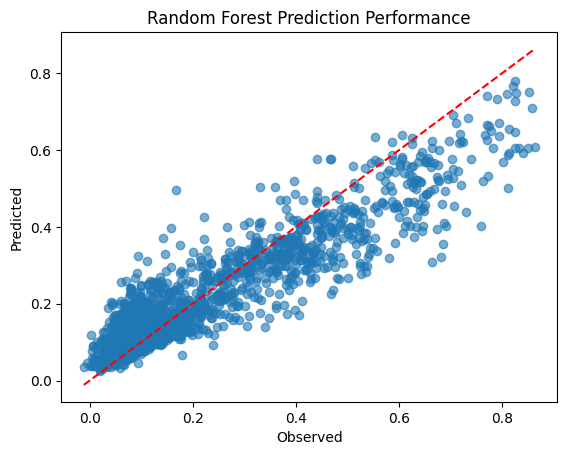

In [16]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Random Forest Prediction Performance")
plt.show()

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# 10-fold cross-validation on training data using best_rf_model
rf_cv_scores_10fold = cross_val_score(
    best_rf_model, X_train, y_train, 
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rf_cv_rmse = np.sqrt(-rf_cv_scores_10fold.mean())
print(f"RF 10-fold CV RMSE (training set estimate): {rf_cv_rmse:.4f}")

# Train the best model on the full training data
best_rf_model.fit(X_train, y_train)

# Predict on test data and evaluate
y_pred_rf = best_rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# Mean Absolute Percentage Error (MAPE) - avoid division by zero
non_zero_mask = y_test != 0
rf_mape = np.mean(np.abs((y_test[non_zero_mask] - y_pred_rf[non_zero_mask]) / y_test[non_zero_mask])) * 100

# Accuracy at different tolerance levels
tolerances = [0.05, 0.10, 0.15, 0.20]  # ±5%, ±10%, ±15%, ±20%
accuracy_data = {}

for tol in tolerances:
    within_tol = np.abs((y_pred_rf - y_test) / y_test) <= tol
    accuracy = np.mean(within_tol) * 100
    accuracy_data[f'±{int(tol*100)}%'] = [accuracy]

accuracy_matrix = pd.DataFrame(accuracy_data, index=['Accuracy (%)'])

# Print final test set performance metrics
print(f"\nRF Test Performance on unseen test set:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"MAPE: {rf_mape:.2f}%")
print(f"R²: {rf_r2:.4f}")
print("\nAccuracy Matrix:")
print(accuracy_matrix)


RF 10-fold CV RMSE (training set estimate): 0.0731

RF Test Performance on unseen test set:
RMSE: 0.0698
MAE: 0.0468
MAPE: 47.72%
R²: 0.8443

Accuracy Matrix:
                    ±5%       ±10%       ±15%       ±20%
Accuracy (%)  12.564103  25.470085  36.923077  46.923077


# Prediction to Raster

In [22]:
import rasterio
import numpy as np
import pandas as pd
from rasterio.transform import from_origin

# Path to your GSE raster stack (10 m resolution)
gse_stack_path = '/Users/ceedindia/Desktop/Fire/Data/Trial/GSE_Dirang_Prediction_Band.tif'

# Open the raster stack
with rasterio.open(gse_stack_path) as src:
    gse_stack = src.read()  # shape: (bands, rows, cols)
    profile = src.profile
    print("Bands:", src.count, " | Shape:", gse_stack.shape)

# Reshape raster data for prediction
n_bands, n_rows, n_cols = gse_stack.shape
gse_2d = gse_stack.reshape(n_bands, -1).T  # shape: (pixels, bands)

Bands: 130  | Shape: (130, 179, 246)


In [23]:
# Assuming you trained with feature columns 'band_1', 'band_2', ..., 'band_n'
feature_names = [col for col in X_train.columns]
print("Feature order preserved:", feature_names)

Feature order preserved: ['band_1', 'band_6', 'band_9', 'band_26', 'band_27', 'band_28', 'band_30', 'band_31', 'band_33', 'band_37', 'band_38', 'band_39', 'band_40', 'band_41', 'band_44', 'band_49', 'band_52', 'band_61', 'band_63', 'band_66']


In [25]:
import numpy as np
import rasterio

# Load the GSE raster stack
with rasterio.open(gse_stack_path) as src:
    gse_stack = src.read()  # shape: (bands, rows, cols)
    profile = src.profile
    print("Bands in full GSE stack:", src.count)

n_bands, n_rows, n_cols = gse_stack.shape

# Reshape the raster to (pixels, bands)
gse_2d = gse_stack.reshape(n_bands, -1).T  # shape: (pixels, bands)

# ---------------------------------------
# ✅ Select only the bands used during training
# ---------------------------------------

# Suppose your training used columns like 'band_1'...'band_20'
# Extract the numeric band indices from column names
train_band_indices = [int(col.split('_')[-1]) - 1 for col in X_train.columns]  
# (subtract 1 because raster bands are 0-indexed in numpy)

# Subset gse_2d to only those bands (and preserve order)
gse_2d_selected = gse_2d[:, train_band_indices]

print(f"Shape before selection: {gse_2d.shape}")
print(f"Shape after selection:  {gse_2d_selected.shape}")
print(f"Model expects:          {best_rf_model.n_features_in_} features")



Bands in full GSE stack: 130
Shape before selection: (44034, 130)
Shape after selection:  (44034, 20)
Model expects:          20 features


In [27]:
# ---------------------------------------
# Predict in batches
# ---------------------------------------
batch_size = 500000
preds = []

for i in range(0, gse_2d_selected.shape[0], batch_size):
    batch = gse_2d_selected[i:i+batch_size]
    preds_batch = best_rf_model.predict(batch)
    preds.extend(preds_batch)

preds = np.array(preds)

# Reshape predictions back to raster grid
predicted_dnbr_10m = preds.reshape(n_rows, n_cols)

# Save predicted map
profile.update(dtype=rasterio.float32, count=1, compress='lzw')
output_path = '/Users/ceedindia/Desktop/Fire/Data/Trial/predicted_dNBR_10m__.tif'

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(predicted_dnbr_10m.astype(np.float32), 1)

print(f"✅ Predicted dNBR (10m) saved at: {output_path}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


✅ Predicted dNBR (10m) saved at: /Users/ceedindia/Desktop/Fire/Data/Trial/predicted_dNBR_10m__.tif


# =============================================================================================================================================

Step 8: XGBoost with Hyperparameter Tuning

In [17]:
import xgboost as xgb

# XGBoost hyperparameter grid
xgb_param_grid = {
    'n_estimators': [500, 1500, 2000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

print("\nXGBoost hyperparameter tuning (10-fold CV)...")
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

xgb_grid_search.fit(X_train, y_train)

print(f"\nBest XGBoost parameters: {xgb_grid_search.best_params_}")
best_xgb_model = xgb_grid_search.best_estimator_



XGBoost hyperparameter tuning (10-fold CV)...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.6; total time=  18.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.6; total time=  18.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.6; total time=  19.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=1.0; total time=  17.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.8; total time=  19.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.8; total time=  19.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=0.8; total time=  19.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=1500, subsample=1.0; total time=  18.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_d

Step 9: Evaluate XGBoost

In [18]:
# # 5-fold CV
# xgb_cv_scores_5fold = cross_val_score(
#     best_xgb_model, X_train, y_train, 
#     cv=10, 
#     scoring='neg_mean_squared_error',
#     n_jobs=-1
# )

# print(f"XGBoost 5-fold CV RMSE: {np.sqrt(-xgb_cv_scores_5fold.mean()):.4f}")

# # Test set evaluation
# y_pred_xgb = best_xgb_model.predict(X_test)

# xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
# xgb_r2 = r2_score(y_test, y_pred_xgb)

# print(f"\nXGBoost Test Performance:")
# print(f"RMSE: {xgb_rmse:.4f}")
# print(f"R²: {xgb_r2:.4f}")

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# -----------------------------
# 10-fold Cross-Validation
# -----------------------------
xgb_cv_scores_5fold = cross_val_score(
    best_xgb_model, X_train, y_train, 
    cv=10, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

print(f"XGBoost 5-fold CV RMSE: {np.sqrt(-xgb_cv_scores_5fold.mean()):.4f}")

# -----------------------------
# Test Set Evaluation
# -----------------------------
y_pred_xgb = best_xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)

# Mean Absolute Percentage Error (MAPE)
xgb_mape = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

xgb_r2 = r2_score(y_test, y_pred_xgb)

# -----------------------------
# Accuracy Matrix (within tolerance)
# -----------------------------
tolerances = [0.05, 0.10, 0.15, 0.20]  # ±5%, ±10%, ±15%, ±20%
accuracy_data = {}

for tol in tolerances:
    within_tol = np.abs((y_pred_xgb - y_test) / y_test) <= tol
    accuracy = np.mean(within_tol) * 100
    accuracy_data[f'±{int(tol*100)}%'] = [accuracy]

accuracy_matrix = pd.DataFrame(accuracy_data, index=['Accuracy (%)'])

# -----------------------------
# Print Results
# -----------------------------
print(f"\nXGBoost Test Performance:")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"MAPE: {xgb_mape:.2f}%")
print(f"R²: {xgb_r2:.4f}")

print("\nAccuracy Matrix:")
print(accuracy_matrix)


XGBoost 5-fold CV RMSE: 0.0609

XGBoost Test Performance:
RMSE: 0.0554
MAE: 0.0365
MAPE: 37.60%
R²: 0.9018

Accuracy Matrix:
                    ±5%       ±10%       ±15%       ±20%
Accuracy (%)  15.213675  31.495726  45.897436  56.752137


Step 10: Convert 10m Prediction Bands to DataFrame (for Prediction)
Now, load the original 10m prediction bands to predict dNBR at 10m resolution:

In [19]:
# def raster_to_dataframe_10m(prediction_10m_path):
#     """
#     Convert 10m prediction bands to dataframe for prediction
#     """
#     with rasterio.open(prediction_10m_path) as pred_src:
#         pred_data = pred_src.read()
#         n_bands = pred_src.count
#         height = pred_src.height
#         width = pred_src.width
#         transform = pred_src.transform
        
#         # Get coordinates
#         rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
#         xs, ys = rasterio.transform.xy(transform, rows.flatten(), cols.flatten())
        
#         # Flatten
#         pred_data_flat = pred_data.reshape(n_bands, -1).T
        
#         # Create dataframe
#         df = pd.DataFrame(pred_data_flat, 
#                          columns=[f'band_{i+1}' for i in range(n_bands)])
#         df['longitude'] = xs
#         df['latitude'] = ys
#         df['row'] = rows.flatten()
#         df['col'] = cols.flatten()
    
#     # Remove nodata
#     df = df.replace([np.inf, -np.inf], np.nan)
#     df = df.dropna()
    
#     return df, height, width, transform

# # Load 10m prediction data
# df_pred_10m, height_10m, width_10m, transform_10m = raster_to_dataframe_10m(
#     '/Users/ceedindia/Desktop/Fire/Data/Trial/GSE_Dirang_Prediction_Band_after64.tif'
# )

# print(f"10m prediction data shape: {df_pred_10m.shape}")


Step 11: Predict dNBR at 10m Resolution
Use the trained model (trained on 20m data) to predict dNBR at 10m resolution:​

In [20]:
# # Extract features for prediction
# X_pred_10m = df_pred_10m[feature_cols]

# # Choose best model
# if rf_r2 > xgb_r2:
#     print("\nUsing Random Forest for 10m prediction")
#     final_model = best_rf_model
# else:
#     print("\nUsing XGBoost for 10m prediction")
#     final_model = best_xgb_model

# # Predict dNBR at 10m
# predicted_dnbr_10m = final_model.predict(X_pred_10m)

# print(f"Predicted dNBR at 10m: {predicted_dnbr_10m.shape}")


Step 12: Convert Predictions Back to 10m Raster

In [21]:
# def predictions_to_raster_10m(predictions, df_coords, height, width, transform, output_path, reference_path):
#     """
#     Convert 10m predictions back to georeferenced raster
#     """
#     with rasterio.open(reference_path) as src:
#         profile = src.profile.copy()
    
#     # Create empty array
#     pred_array = np.full((height, width), np.nan, dtype=np.float32)
    
#     # Fill with predictions
#     for idx, (row, col, pred) in enumerate(zip(df_coords['row'], 
#                                                  df_coords['col'], 
#                                                  predictions)):
#         pred_array[int(row), int(col)] = pred
    
#     # Update profile
#     profile.update({
#         'count': 1,
#         'dtype': 'float32',
#         'height': height,
#         'width': width,
#         'transform': transform,
#         'nodata': np.nan
#     })
    
#     # Write raster
#     with rasterio.open(output_path, 'w', **profile) as dst:
#         dst.write(pred_array, 1)
    
#     print(f"Predicted dNBR raster saved: {output_path}")

# # Save predicted dNBR at 10m
# predictions_to_raster_10m(
#     predicted_dnbr_10m,
#     df_pred_10m,
#     height_10m,
#     width_10m,
#     transform_10m,
#     'predicted_dnbr_10m.tif',
#     'prediction_bands_10m.tif'
# )
